# Circles Synthetic Experiment

This notebook reproduces results for the circles synthetic experiment in the main text. 

**Goal**: given two assymteric circles constructed such that one side of the circle is more weighted than other, find trajectories between particles w.r.t purely rotational reference velocity drift i.e $\omega = \text{const}$.

In [1]:
import math
import sys, os
sys.path.insert(0, os.path.abspath(".."))
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from tqdm import tqdm
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons
import torchcfm
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from sklearn.datasets import make_circles
from torchcfm.optimal_transport import OTPlanSampler
from src.models.components.single_marginal_utils import *
from src.models.components.mlp import *

2025-11-30 14:28:33.672022: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 14:28:33.689787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764512913.708111 3553183 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764512913.713434 3553183 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764512913.730232 3553183 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
from torch.func import vmap
import scipy

# Construct a purely rotational reference process
def psi_xt(xt):
    omega = np.pi
    x = xt[..., 0]
    y = xt[..., 1]
    vx = omega * y  
    vy = - omega * x
    psi = torch.stack([vx, vy], dim=-1)  
    return psi

def coupling(x0, x1, batch_size, geodesic_model, sigma):
    t = torch.rand(1).type_as(x0) * torch.ones(batch_size, batch_size)
    x0_r = x0.repeat(batch_size, 1, 1)
    x1_r = x1.repeat(batch_size, 1, 1).transpose(0, 1)
    xt, mu_t_dot, eps = get_xt_xt_dot(t, x0_r, x1_r, geodesic_model, sigma=sigma)
    ut = psi_xt(xt.detach())
    L2_cost = 0.5*((mu_t_dot.detach() - ut)**2).sum(-1)
    _, col_ind = scipy.optimize.linear_sum_assignment(L2_cost.detach().cpu().numpy())
    pi_x0 = x0[col_ind]
    pi_x1 = x1
    return pi_x0, pi_x1

## Assymetric Circles

In [3]:
def generate_single_asymmetric_circle(n_samples=500, noise=0.01, bias_direction='right'):
    X, _ = make_circles(n_samples=n_samples, noise=noise, factor=0.9)
    bias_weights = np.ones(len(X))
    bias_weights = np.ones(len(X))
    if bias_direction == 'right':
        bias_weights += X[:, 0]  # More weight on the right side (positive x)
    elif bias_direction == 'left':
        bias_weights -= X[:, 0]  # More weight on the left side (negative x)
    elif bias_direction == 'top':
        bias_weights += X[:, 1]  # More weight on the top side (positive y)
    elif bias_direction == 'bottom':
        bias_weights -= X[:, 1]  # More weight on the bottom side (negative y)
    
    # Sample points based on the bias weights
    bias_weights = np.clip(bias_weights, 0, None)  
    indices = np.random.choice(len(X), size=n_samples, p=bias_weights / bias_weights.sum(), replace=True)
    X_biased = X[indices]
    
    return torch.tensor(X_biased, dtype=torch.float32)

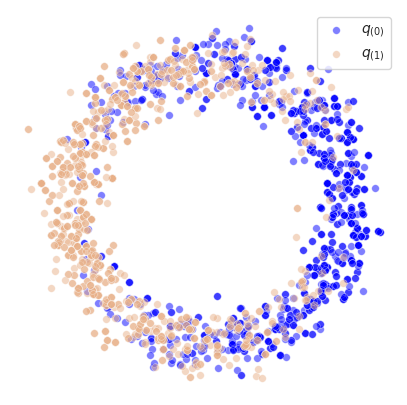

In [4]:
x0 = generate_single_asymmetric_circle(n_samples=1024, noise=0.1, bias_direction='right')
x1 = generate_single_asymmetric_circle(n_samples=1024, noise=0.1, bias_direction='left')

# Visualize created dataset
plot_x(x0, x1)

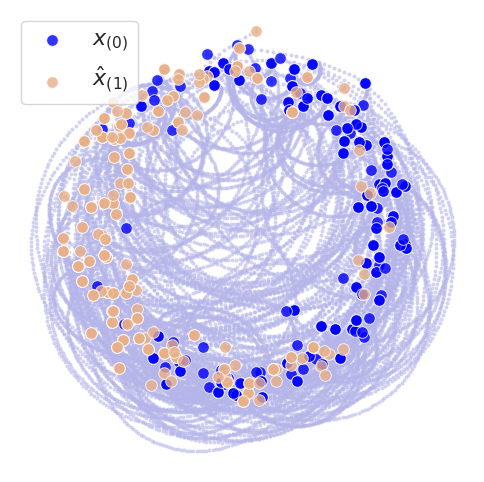

10000: time 41.61


In [5]:
# Algorithm 1: Training neural bridge
sigma = 0.01
dim = 2
batch_size = 256
geodesic_model = MLP(dim=dim*2, out_dim=dim, time_varying=True)
optimizer_psi = torch.optim.Adam(list(geodesic_model.parameters()))
w2s = []
time_list = []
start = time.time()

# Training loop for psi_t and xt_dot
for k in range(10000):
    optimizer_psi.zero_grad()
    x0 = generate_single_asymmetric_circle(n_samples=batch_size, noise=0.1, bias_direction='right')
    x1 = generate_single_asymmetric_circle(n_samples=batch_size, noise=0.1, bias_direction='left')
    t = torch.rand(x0.shape[0]).type_as(x0)
    xt, mu_t_dot, eps = get_xt_xt_dot(t, x0, x1, geodesic_model, sigma=sigma)
    psi = psi_xt(xt.detach())
    coss_loss_psi = 1-torch.nn.functional.cosine_similarity(psi , mu_t_dot).mean()
    l2_loss_psi = torch.mean((mu_t_dot - psi) ** 2)
    loss_psi = l2_loss_psi + coss_loss_psi
    loss_psi.backward()
    optimizer_psi.step()

traj = []
end = time.time()
with torch.no_grad():
    for t in torch.linspace(0, 1, 100): 
        t = t.type_as(x0).repeat(x0.shape[0])
        t = t[:,None]
        xt_traj = get_xt(t, x0, x1, geodesic_model)[1]
        traj.append(xt_traj)

traj = torch.stack(traj)

plot_trajectories_2(traj.cpu().numpy())

print(f"{k+1}: time {(end - start):0.2f}")

/slurm-storage/katpet/.local/lib/python3.11/site-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


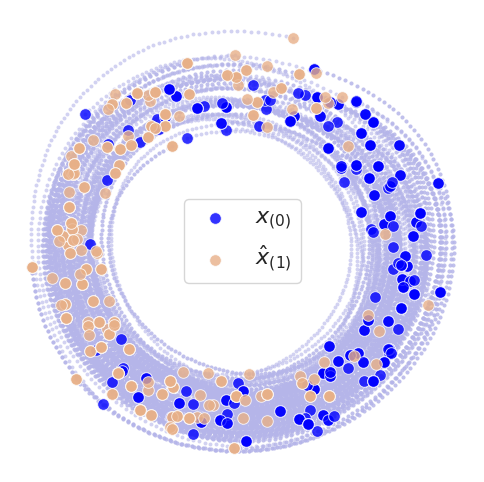

10000: loss 0.045 time 418.57 w2 0.134


In [6]:
model = MLP(dim=dim, time_varying=True)
optimizer_velocity = torch.optim.Adam(list(model.parameters()))
for k in range(10000):
    optimizer_velocity.zero_grad()
    x0 = generate_single_asymmetric_circle(n_samples=batch_size, noise=0.1, bias_direction='right')
    x1 = generate_single_asymmetric_circle(n_samples=batch_size, noise=0.1, bias_direction='left')
    x0, x1 = coupling(x0, x1, x0.shape[0], geodesic_model, sigma=sigma)
    t = torch.rand(x0.shape[0]).type_as(x0)
    xt, mu_t_dot, eps = get_xt_xt_dot(t, x0, x1, geodesic_model, sigma=sigma)
    vt = model(torch.cat([xt.detach(), t[:, None]], dim=-1))
    loss = torch.mean((vt - mu_t_dot.detach()) ** 2)
    loss.backward()
    optimizer_velocity.step()

end = time.time()

node = NeuralODE(
    torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node.trajectory(
        x0,
        t_span=torch.linspace(0, 1, 100),
    )
    if (k + 1) % 10000 == 0:
        torch.save(traj, f"traj_{k}.pt")
    plot_trajectories_2(traj.cpu().numpy())

w2 = torchcfm.optimal_transport.wasserstein(traj[-1], x1)
w2s.append(w2)
print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f} w2 {w2:0.3f}")
start = end